# RADIA Example 3: Simple U46 Hybrid Undulator

This example creates and solves a simple U46 Hybrid Undulator made with
rectangular blocks.

To obtain an acceptable precision for the magnetic field, it is essential to
increase the segmentation, which, of course, requires more memory and CPU time.
The initial segmentation in this example has been set to `nsp = [2,2,5]` for
the pole and `nsm = [1,3,1]` for the magnet. These settings yield an absolute
error of order 1% in the peak field of the undulator. The user can vary both
`nsp` and `nsm` (in the section **_Create the undulator magnet_**) and assess the consequences
for memory usage, CPU time, and convergence of the peak field value. As a rule,
the iron will require finer segmentation because its magnetization is more
sensitive to the external field.

One can also—for undulators such as this one—compute field integrals and forces
on the magnets and poles. In addition, one can build a wedge-pole undulator by
using polyhedrons or extruded polygons instead of rectangular blocks. To learn
more, read the [Radia documentation](
  https://www.esrf.eu/Accelerators/Groups/InsertionDevices/Software/Radia/Documentation
  "RADIA documentation at ESRF"),
experiment with the code, and develop experience.

## _Import Radia and other packages_

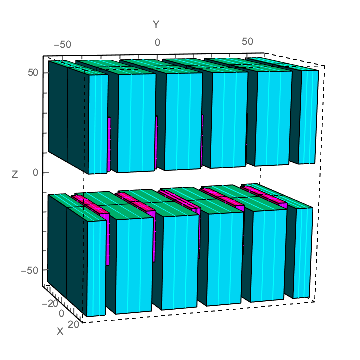

In [1]:
%matplotlib inline
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import time as tm

import radia as rad
import ipywidgets
from jupyter_rs_radia import radia_viewer

# import an illustration of this magnet
from IPython.display import Image
Image(filename=('./U46HybridUnd.png'))

## _Define function to build the undulator_

We here define a function that constructs the desired undulator geometry in Radia.
It constructs in Radia an array of rectangular permanent magnets and iron blocks,
each with given dimensions, magnetization, segmentation, material properties,
and colors (for plotting). It then constructs their mirror symmetric counterparts.
The function is generic and can be used to build almost any hybrid undulator—though
without optimizing the design of terminations.

In [12]:
def undulator(lp,ep,mp,nmp,cp,lm,em,mm,nmm,cm,lsm,nsm,csm,lep,les,dpm,gap,sep,gapOffset,numPer):
    """
    create hybrid undulator magnet
    arguments:
      lp = [lpx, lpy, lpz] = dimensions of the iron poles / mm
      mp = magnetic properties of the iron poles (M-H curve)
      np = segmentation of the iron poles
      cp = [r,g,b] = color for the iron poles
      lm = [lmx, lmy, lmz] = dimensions of the magnet blocks / mm
      mm = magnetic properties of the magnet blocks (remanent magnetization)
      nm = segmentation of the magnet blocks
      cm = [r,g,b] = color for the magnet blocks
      gap = undulator gap / mm
      gapOffset = vertical offset / mm of the magnet blocks w/rt the poles
      numPer = number of full periods of the undulator magnetic field
    return: Radia representations of
      undulator group, poles, permanent magnets
    """
    zer = [0,0,0]

    # full magnet will be assembled into this Radia group
    grp = rad.ObjCnt([])

    # principal poles and magnet blocks in octant(+,+,–)
    # -- half pole
    y = lp[1]/4
    p1=[[lp[0]/4-ep[0]/2,y-ep[1]/2,sep[2]+gap/2],[lp[0]/2-ep[1],lp[1]/2-ep[1]]]
    p2=[[lp[0]/4,y,ep[2]+sep[2]+gap/2],[lp[0]/2,lp[1]/2]]
    p3=[[lp[0]/4,y,lp[2]+sep[2]+gap/2],[lp[0]/2,lp[1]/2]]
    pole0 = rad.ObjMltExtRtg([p1,p2,p3],zer)
    rad.ObjDivMag(pole0, nmp)
    rad.MatApl(pole0, mp)
    rad.ObjDrwAtr(pole0, cp)
    rad.ObjAddToCnt(grp, [pole0])
    
    # -- First side magnet
    mDir = -1
    initM = [mDir, 0, 0]
    m1=[[(lp[0]-ep[0]+lsm[0]-em[0])/2+sep[0],y-ep[1]/2,sep[2]+gap/2],[ep[0]+lsm[0]-em[0],lsm[1]/2-ep[1]]]
    m2=[[(lp[0]+lsm[0])/2+sep[0],y,em[2]+sep[2]+gap/2],[lsm[0],lsm[1]/2]]
    m3=[[(lp[0]+lsm[0])/2+sep[0],y,lsm[2]+sep[2]+gap/2],[lsm[0],lsm[1]/2]]
    side0 = rad.ObjMltExtRtg([m1,m2,m3], initM)
    rad.ObjDivMag(side0, nsm)
    rad.MatApl(side0, mm)
    rad.ObjDrwAtr(side0, csm)
    rad.ObjAddToCnt(grp, [side0])

    y += lp[1]/4
    # -- magnet and pole pairs
    for i in range(0, numPer):
        initM = [0, mDir, 0]; mDir *= -1
        y += lm[1]/4+sep[1]
        m1=[[lm[0]/4-em[0]/2,y-em[1]/2, sep[2]+gap/2+gapOffset],[lm[0]/2-em[0],lm[1]/2+em[1]]]
        m2=[[lm[0]/4,y,em[2] + sep[2]+gap/2+gapOffset],[lm[0]/2,lm[1]/2]]
        m3=[[lm[0]/4,y,lm[2] + sep[2]+gap/2+gapOffset],[lm[0]/2,lm[1]/2]]
        magnetA = rad.ObjMltExtRtg([m1,m2,m3], initM)
        rad.ObjDivMag(magnetA, nmm)
        rad.MatApl(magnetA, mm)
        rad.ObjDrwAtr(magnetA, cm)
        rad.ObjAddToCnt(grp, [magnetA])
        y += lm[1]/2+sep[1]
        m1=[[lm[0]/4-em[0]/2,y+em[1]/2, sep[2]+gap/2+gapOffset],[lm[0]/2-em[0],lm[1]/2+em[1]]]
        m2=[[lm[0]/4,y,em[2] + sep[2]+gap/2+gapOffset],[lm[0]/2,lm[1]/2]]
        m3=[[lm[0]/4,y,lm[2] + sep[2]+gap/2+gapOffset],[lm[0]/2,lm[1]/2]]
        magnetB = rad.ObjMltExtRtg([m1,m2,m3], initM)
        rad.ObjDivMag(magnetB, nmm)
        rad.MatApl(magnetB, mm)
        rad.ObjDrwAtr(magnetB, cm)
        rad.ObjAddToCnt(grp, [magnetB])
        
        # -- Pole
        y += (lm[1]/2 + lp[1])/2+sep[1]
        p1=[[lp[0]/4-ep[0]/2,y,sep[2]+gap/2],[lp[0]/2-ep[0],lp[1]-2*ep[1]]]
        p2=[[lp[0]/4,y,ep[2]+sep[2]+gap/2],[lp[0]/2,lp[1]]]
        p3=[[lp[0]/4,y,lp[2]+sep[2]+gap/2],[lp[0]/2,lp[1]]]
        poleA = rad.ObjMltExtRtg([p1,p2,p3],zer)
        npd = [nmp[0], nmp[1]*2, nmp[2]]
        rad.ObjDivMag(poleA, npd)
        rad.MatApl(poleA, mp)
        rad.ObjDrwAtr(poleA, cp)
        rad.ObjAddToCnt(grp, [poleA])
        
        # -- Periodic side magnet
        initM =  [mDir, 0, 0]
        m1=[[(lp[0]-ep[0]+lsm[0]-em[0])/2+sep[0],y,sep[2]+gap/2+gapOffset],[ep[0]+lsm[0]-em[0],lsm[1]-2*ep[1]]]
        m2=[[(lp[0]+lsm[0])/2+sep[0],y,em[2]+sep[2]+gap/2+gapOffset],[lsm[0],lsm[1]]]
        m3=[[(lp[0]+lsm[0])/2+sep[0],y,lsm[2]+sep[2]+gap/2+gapOffset],[lsm[0],lsm[1]]]
        sideA = rad.ObjMltExtRtg([m1,m2,m3], initM)
        nsmd = [nsm[0], nsm[1]*2, nsm[2]]
        rad.ObjDivMag(sideA, nsmd)
        rad.MatApl(sideA, mm)
        rad.ObjDrwAtr(sideA, csm)
        rad.ObjAddToCnt(grp, [sideA])
        y += lp[1]/2
        
        if i == 0:
            magnet1=rad.ObjCnt([magnetA, magnetB])
            pole1=rad.ObjCnt([poleA])
            side1=rad.ObjCnt([sideA])
        else:
            rad.ObjAddToCnt(magnet1, [magnetA, magnetB])
            rad.ObjAddToCnt(pole1, [poleA])
            rad.ObjAddToCnt(side1, [sideA])
        
    # -- end magnet block
    initM = [0, mDir, 0]
    y += lm[1]/2+sep[1]
    m1=[[lm[0]/4-em[0]/2,y,sep[2]+gap/2+gapOffset],[lm[0]/2-em[0],lm[1]+2*em[1]]]
    m2=[[lm[0]/4,y,em[2]+sep[2]+gap/2+gapOffset],[lm[0]/2,lm[1]]]
    m3=[[lm[0]/4,y,lm[2]+sep[2]+gap/2+gapOffset],[lm[0]/2,lm[1]]]
    magnet2=rad.ObjMltExtRtg([m1,m2,m3],initM)
    nmd = [nmm[0], nmm[1]*2, nmm[2]]
    rad.ObjDivMag(magnet2, nmd)
    rad.MatApl(magnet2, mm)
    rad.ObjDrwAtr(magnet2, cm)
    rad.ObjAddToCnt(grp, [magnet2])
    
    # -- End pole
    y+=(lm[1]+lep[1])/2+sep[1]+dpm[0]
    p1=[[lep[0]/4-ep[0]/2,y,sep[2]+gap/2],[lep[0]/2-ep[0],lep[1]-2*ep[1]]]
    p2=[[lep[0]/4,y,ep[2]+sep[2]+gap/2],[lep[0]/2,lep[1]]]
    p3=[[lep[0]/4,y,lep[2]+sep[2]+gap/2],[lep[0]/2,lep[1]]]
    pole2=rad.ObjMltExtRtg([p1,p2,p3],zer)
    rad.ObjDivMag(pole2, nmp)
    rad.MatApl(pole2, mp)
    rad.ObjDrwAtr(pole2, cp)
    rad.ObjAddToCnt(grp, [pole2])

    # -- End side magnet
    initM = [-1*mDir, 0, 0]
    m1=[[(lep[0]-ep[0]+les[0]-em[0])/2+sep[0],y,sep[2]+gap/2+gapOffset],[ep[0]+les[0]-em[0],les[1]-2*ep[1]]]
    m2=[[(lep[0]+les[0])/2+sep[0],y,em[2]+sep[2]+gap/2+gapOffset],[les[0],les[1]]]
    m3=[[(lep[0]+les[0])/2+sep[0],y,les[2]+sep[2]+gap/2+gapOffset],[les[0],les[1]]]
    side2=rad.ObjMltExtRtg([m1,m2,m3],initM)
    nsmd = [nsm[0], nsm[1]*2, nsm[2]]
    rad.ObjDivMag(side2, nsmd)
    rad.MatApl(side2, mm)
    rad.ObjDrwAtr(side2, csm)
    rad.ObjAddToCnt(grp, [side2])
    
    # -- End magnet for half size and unit model
    initM = [0, -1*mDir, 0]
    y+=lm[1]/4+lep[1]/2+sep[1]+dpm[1]
    m1=[[lm[0]/4-em[0]/2,y-em[1]/2,sep[2]+gap/2+gapOffset],[lm[0]/2-em[0],lm[1]/2+em[1]]]
    m2=[[lm[0]/4,y,em[2]+sep[2]+gap/2+gapOffset],[lm[0]/2,lm[1]/2]]
    m3=[[lm[0]/4,y,lm[2]+sep[2]+gap/2+gapOffset],[lm[0]/2,lm[1]/2]]
    magnet3=rad.ObjMltExtRtg([m1,m2,m3],initM)
    rad.ObjDivMag(magnet3, nmm)
    rad.MatApl(magnet3, mm)
    rad.ObjDrwAtr(magnet3, cm)
    rad.ObjAddToCnt(grp, [magnet3])
    
    # use mirror symmetry to define the full undulator
    rad.TrfZerPerp(grp, zer, [1,0,0]) # reflect in the (y,z) plane
    rad.TrfZerPara(grp, zer, [0,0,1]) # reflect in the (x,y) plane
    rad.TrfZerPerp(grp, zer, [0,1,0]) # reflect in the (z,x) plane
    
    magnet = rad.ObjCnt([magnet1, magnet2, magnet3])
    side = rad.ObjCnt([side0, side1, side2])
    pole = rad.ObjCnt([pole0,pole1,pole2])
    
    return grp, pole, magnet, side, magnet2, pole2

In [2]:
# this version supplies a work-around for the viz bug
def undulatorX(lp, mp, np, cp,  lm, mm, nm, cm,  gap, gapOffset, numPer):
    """
    create hybrid undulator magnet
    arguments:
      lp = [lpx, lpy, lpz] = dimensions of the iron poles / mm
      mp = magnetic properties of the iron poles (M-H curve)
      np = segmentation of the iron poles
      cp = [r,g,b] = color for the iron poles
      lm = [lmx, lmy, lmz] = dimensions of the magnet blocks / mm
      mm = magnetic properties of the magnet blocks (remanent magnetization)
      nm = segmentation of the magnet blocks
      cm = [r,g,b] = color for the magnet blocks
      gap = undulator gap / mm
      gapOffset = vertical offset / mm of the magnet blocks w/rt the poles
      numPer = number of full periods of the undulator magnetic field
    return: Radia representations of
      undulator group, poles, permanent magnets
    """
    zer = [0,0,0]

    # full magnet will be assembled in the following Radia groups
    grp_m = rad.ObjCnt([])            # iron magnet
    grp_p = rad.ObjCnt([])            # permanent magnet poles
    grp = rad.ObjCnt([grp_m, grp_p])  # full magnet

    # principal poles and magnet blocks in octant(+,+,–)
    # -- half pole
    y = lp[1]/4
    pole = rad.ObjFullMag([lp[0]/4,    y,    -lp[2]/2 - gap/2],
                          [lp[0]/2, lp[1]/2,  lp[2]          ], zer, np, grp_p, mp, cp)
    y += lp[1]/4
    # -- magnet and pole pairs
    mDir = -1
    for i in range(0, numPer):
        initM = [0, mDir, 0]; mDir *= -1
        y += lm[1]/2
        magnet = rad.ObjFullMag([lm[0]/4,   y,   -lm[2]/2 - gap/2 - gapOffset],
                                [lm[0]/2, lm[1],  lm[2]                      ], initM, nm, grp_m, mm, cm)
        y += (lm[1] + lp[1])/2
        pole = rad.ObjFullMag([lp[0]/4,   y,   -lp[2]/2 - gap/2],
                              [lp[0]/2, lp[1],  lp[2]          ], zer, np, grp_p, mp, cp)
        y += lp[1]/2
    # -- end magnet block
    initM = [0, mDir, 0]
    y += lm[1]/4;
    magnet = rad.ObjFullMag([lm[0]/4,   y,     -lm[2]/2 - gap/2 - gapOffset],
                            [lm[0]/2, lm[1]/2,  lm[2]                      ], initM, nm, grp_m, mm, cm)

    # use mirror symmetry to define the full undulator
    rad.TrfZerPerp(grp_m, zer, [1,0,0]) # reflect in the (y,z) plane
    rad.TrfZerPara(grp_m, zer, [0,0,1]) # reflect in the (x,y) plane
    rad.TrfZerPerp(grp_m, zer, [0,1,0]) # reflect in the (z,x) plane
    
    # use mirror symmetry to define the full undulator
    rad.TrfZerPerp(grp_p, zer, [1,0,0]) # reflect in the (y,z) plane
    rad.TrfZerPara(grp_p, zer, [0,0,1]) # reflect in the (x,y) plane
    rad.TrfZerPerp(grp_p, zer, [0,1,0]) # reflect in the (z,x) plane
    
    return grp, pole, magnet

## _Define functions for the magnetic materials and fields_

The first of the following functions returns a Radia representation of the magnetization curves _M_ (in Tesla) vs _H_ (in Amp/m) for both the pole tips and the magnets. The material for the poles is defined by calling the function `rad.MatSatIsoTab` with the data table `ma`, which contains the paired values of _H_ and _M_, both expressed in Tesla. (The conversion of _H_ in Amp/m to Tesla is accomplished simply by multiplying _H_ by _μ<sub>o</sub>_, i.e. `4*pi/10^7`.) The material for the permanent magnets is defined by calling `rad.MatStd`, with arguments _material type_ and _remanent magnetization_. We will later plot the resulting _M_(_H_) curves for verification.

The next function extracts magnetic field information from a given magnetic material defined by Radia. This allows us to plot the _M_(_H_) curves tocompare with our input data. And the third function calculates (for a _solved_ Radia magnet) the vertical field along the Y (longitudinal) axis.

In [13]:
# magnetic constant (vacuum magnetic permeability)
mu0 = 4 * np.pi / 1e7

def materials(H, M,  smat, rm):
    """
    define magnetic materials for the undulator poles and magnets
    arguments:
      H    = list of magnetic field values / (Amp/m)
      M    = corresponding magnetization values / T
      smat = material type string
      rm   = remanent magnetization / T
    return: Radia representations of ...
      pole-tip material, magnet material
    """
    # -- magnetic property of poles
    #convH = 4. * np.pi / 1.0e7
    ma = [[mu0 * H[i], M[i]] for i in range(len(H))]
    mp = rad.MatSatIsoTab(ma)
    # -- permanent magnet material
    mm = rad.MatStd(smat, rm)

    return mp, mm


def getMagnMaterCompMvsH(meshH, ind, cmpnH,  cmpnM):
    """
    extract magnetization M_comp vs field strength H_comp from material data
    arguments:
      meshH = how to mesh the H axis: [hmin, hmax, nh]
      ind   = magnet material index
      cmpnH = component of H ('x', 'y', or 'z')
      cmpnM = component of M ('x', 'y', or 'z')
    return:
      given component of magnetization along the given mesh in H
    """
    hMin = meshH[0]; hMax = meshH[1]; nh = meshH[2]
    hStep = (hMax - hMin) / (nh - 1)
    m = [ 0 ] * nh
    sCmpnM = 'm' + cmpnM
    h = hMin
    H = [0,0,0]
    for i in range(nh):
        if(  cmpnH == 'x'): H[0] = h
        elif(cmpnH == 'y'): H[1] = h
        elif(cmpnH == 'z'): H[2] = h
        m[i] = rad.MatMvsH(ind, sCmpnM, H)
        h += hStep
    return m


def calcField(grp, per, numPer):
    """
    compute vertical magnetic field vs longitudinal position (Y)
    arguments:
      grp    = magnet (Radia group)
      per    = period / mm
      numPer = number of full magnetic periods
    return:
      Bz(y), meshY
    """
    xc = 0 # transverse X coordinate
    zc = 0 # transverse Z coordinate
    yMax = per * (numPer + 1)
    yMin = -yMax
    ny = 501
    yStep = (yMax - yMin) / ny
    y = np.arange(yMin, yMin + ny * yStep, yStep)
    
    points = [[xc, yi, zc] for yi in y]
    BzVsY = rad.Fld(grp, 'bz', points)

    return BzVsY, [yMin, yMax, ny]

## _Create the undulator magnet_

First enter and plot the data describing the magnetization curve for the iron pole tips.

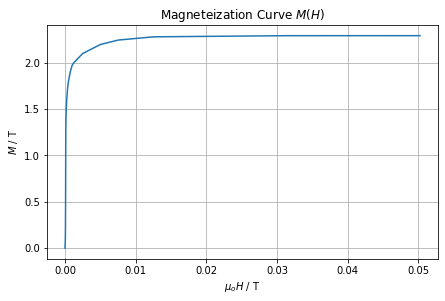

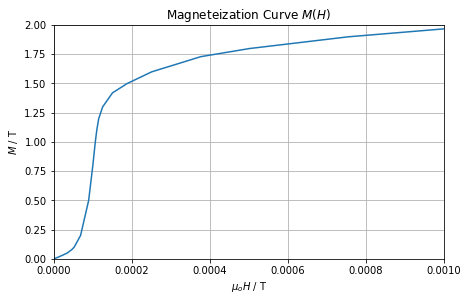

In [14]:
# ~iron type Va Permendur
ironH = [  0.8,   1.5,     2.2,    3.6,    5.0,     6.8,     9.8,    18.0,
          28.0,   37.5,   42.0,   55.0,   71.5,    80.0,    85.0,    88.0,
          92.0,  100.0,  120.0,  150.0,  200.0,   300.0,   400.0,   600.0,
         800.0, 1000.0, 2000.0, 4000.0, 6000.0, 10000.0, 25000.0, 40000.0]
ironM = [0.000998995, 0.00199812, 0.00299724, 0.00499548, 0.00699372, 0.00999145, 0.0149877, 0.0299774,
         0.0499648,   0.0799529,  0.0999472,  0.199931,   0.49991,    0.799899,   0.999893, 1.09989,
         1.19988,     1.29987,    1.41985,    1.49981,    1.59975,    1.72962,    1.7995,   1.89925,
         1.96899,     1.99874,    2.09749,    2.19497,    2.24246,    2.27743,    2.28958,  2.28973]

# full M-H curve
plt.figure(figsize=(7,4.3))
plt.plot([mu0 * h for h in ironH], ironM)
plt.title(r'Magneteization Curve $M(H)$')
plt.xlabel(r'$\mu_o H$ / T')
plt.ylabel(r'$M$ / T')
plt.grid()
plt.show()

# leading edge of M-H curve
plt.figure(figsize=(7,4.3))
plt.plot([mu0 * h for h in ironH], ironM)
plt.title(r'Magneteization Curve $M(H)$')
plt.xlabel(r'$\mu_o H$ / T')
plt.ylabel(r'$M$ / T')
plt.xlim([0,0.001])
plt.ylim([0,2.0])
plt.grid()
plt.show()

Then set the magnet parameters and materials, and “build the magnet”.

In [21]:
# set parameters for this undulator
# -- general parameters
numPer =  2    # number of full magnetic periods
per = 220       # period / mm
gap = 15       # gap height / mm
gapOffset = 0  # 
sep =  [0, 0, 0] # separaters / mm

# -- parameters for the iron poles
lp =  [70,35,90] # dimensions / mm
ep =  [9,9,10]  # chmafer / mm
nmp = [2,2,5]   # pole-tip segmentation (try varying this setting)
cp =  [1,0,1]   # assign color
ll = per/2 - lp[1]

# -- parameters for the magnet blocks
lm  = [120,ll,130] # dimensions / mm
em =  [10,9,10]   # excrusion / mm
nmm = [1,3,1]    # magnet-block segmentation (try varying this)
cm  = [0,1,1]    # assign color

# -- parameters for the side magnet blocks
lsm = [(lm[0]-lp[0])/2,lp[1],110]
nsm = [2,1,1]    # magnet-block segmentation (try varying this)
csm  = [0,0.5,1]    # assign color

# -- parameters for the ending blocks
lep = [lp[0],20,lp[2]]
les = [lsm[0],lep[1],80]
dpm = [0,0]

# -- magnetic materials
# pole tips: ~iron type Va Permendur
# permanent magnets: NdFeB with 1.2 Tesla remanent magnetization
mp, mm = materials(ironH, ironM, 'NdFeB', 1.29)

In [22]:
# then build the undulator
und,pole,magnet,side,magnet2,pole2=undulator(lp,ep,mp,nmp,cp,lm,em,mm,nmm,cm,lsm,nsm,csm,lep,les,dpm,gap,sep,gapOffset,numPer)

# set up the radia viewer and display the magnet
rv = radia_viewer.RadiaViewer()
rv.add_geometry('Simple Dipole Steerer', und)
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

In [17]:
# then build the undulator (work-around version)
und,pole,magnet,side,magnet2,pole2=undulator(lp,ep,mp,nmp,cp,lm,em,mm,nmm,cm,lsm,nsm,csm,lep,les,dpm,gap,sep,gapOffset,numPer)
#undX, pole, magnet = undulatorX(lp, mp, nsp, cp, lm, mm, nsm, cm, gap, gapOffset, numPer)

# set up the radia viewer and display the magnet
rvX = radia_viewer.RadiaViewer()
rvX.add_geometry('Iron Poles',   pole)
rvX.add_geometry('Permanent Magnets',   magnet)
rvX.add_geometry('Simple Dipole Steerer',   und)
rvX.add_geometry('Magnet',   magnet2)
rvX.add_geometry('Pole',   pole2)
#rvX.add_geometry('Simple Dipole Steerer X', undX)
rvX.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

Here plot the magnetization curve (extracted from Radia) for the iron pole tips. These should appear identical to the corresponding plots above.

In [18]:
# full M-H curve
meshH= [0.00, mu0 * ironH[-1], 201]
Mpole = getMagnMaterCompMvsH(meshH, pole2, 'y', 'y')

plt.figure(figsize=(7,4.3))
plt.plot(np.linspace(meshH[0],meshH[1],meshH[2]), Mpole)
plt.title(r'Magneteization Curve $M(H)$')
plt.xlabel(r'$\mu_oH$ / T')
plt.ylabel(r'$M$ / T')
plt.grid()
plt.show()

# leading edge of the M-H curve
meshH= [0.000, 0.001, 101]
Mpole = getMagnMaterCompMvsH(meshH, pole2, 'y', 'y')

plt.figure(figsize=(7,4.3))
plt.plot(np.linspace(meshH[0],meshH[1],meshH[2]), Mpole)
plt.title(r'Magneteization Curve $M(H)$')
plt.xlabel(r'$\mu_oH$ / T')
plt.ylabel(r'$M$ / T')
plt.xlim([0,0.001])
plt.ylim([0,2.0])
plt.grid()
plt.show()

RuntimeError: Incorrect input: Element with that key is neither Material nor 3D object with Material applied.

## _Solve for the undulator magnetization_

Here we ask Radia to solve for the undulator magnetization—_i.e._ for the magnetization within each sub-block that constitutes the undulator—and also report some statistics concerning that solution.

In [19]:
# solve for the magnetization
prec = 0.0003  # precision for this computation
maxIter = 1000 # maximum allowed iterations
t0 = tm.time()
res = rad.Solve(und, prec, maxIter)
t1 = tm.time()

print("Solved for magnetization in {0:6f} s".format(t1 - t0))
print("Relaxation results")
print("  number of iterations: {0:5d}".format(int(res[3])))
print("  average stability of magnetization at last iteration: {0:.4e} T".format(res[0]))
print("  maximum absolute magnetization at last iteration: {0:.5f} T".format(res[1]))
print("  maximum H vector at last iteration: {0:.5f} T".format(res[2]))
print("Peak magnetic field: {0:.8f} T".format(rad.Fld(und, 'bz', [0,0,0])))

Solved for magnetization in 0.514199 s
Relaxation results
  number of iterations:    25
  average stability of magnetization at last iteration: 2.9560e-04 T
  maximum absolute magnetization at last iteration: 2.29845 T
  maximum H vector at last iteration: 1.63630 T
Peak magnetic field: -2.72628950 T


Now ask Radia to compute the magnetic field along the undulator’s longitudinal axis. And then plot the results.

Computed requested field vaues in 1.143328 s



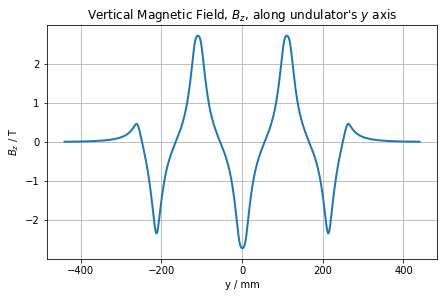

In [20]:
# compute magnetic field values
t2 = tm.time()
BzVsY, MeshY = calcField(und, per, numPer)
t3 = tm.time()
print("Computed requested field vaues in {0:6f} s\n".format(t3 - t2))

# and plot
y = np.linspace(MeshY[0], MeshY[1], MeshY[2])
plt.figure(figsize=(7,4.3))
plt.plot(y, BzVsY, linewidth = 2.0)
plt.title(r"Vertical Magnetic Field, $B_z$, along undulator's $y$ axis")
plt.xlabel('y / mm')
plt.ylabel('$B_z$ / T')
plt.grid()
plt.show()

## _Check the Material Properties_

Here we extract from Radia, and plot, the magnetization curve—magnetization _vs._ field strength—of the pole tip material.

In [29]:
# extract data for the pole tip material
meshH_pole = [-0.0012, 0.0012, 201]
M_pole = getMagnMaterCompMvsH(meshH_pole, pole, 'z', 'z')

# and plot that data
h = np.linspace(1e3*meshH_pole[0], 1e3*meshH_pole[1], meshH_pole[2])
plt.figure(figsize=(7,4.3))
plt.plot(h, M_pole, linewidth = 2.0)
plt.title(r'Magnetization Curve $M(H)$ for pole material')
plt.xlabel('magnetic field strength $\mu_0 H$ / mT')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

# do this again over a wider range of H values
meshH_pole = [-0.01, 0.01, 201]
M_pole = getMagnMaterCompMvsH(meshH_pole, pole, 'x', 'x')

h = np.linspace(1e3*meshH_pole[0], 1e3*meshH_pole[1], meshH_pole[2])
plt.figure(figsize=(7,4.3))
plt.plot(h, M_pole, linewidth = 2.0)
plt.title(r'Magnetization Curve $M(H)$ for pole material')
plt.xlabel('magnetic field strength $\mu_0 H$ / mT')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

RuntimeError: Incorrect input: Element with that key is neither Material nor 3D object with Material applied.

In a similar manner, we extract from Radia, and plot, magnetization curves for the permanent magnet material. In this case, the material has a significant anisotropy, as evidenced by the diffferent results parallel and perpendicular to the so-called “easy” axis.

In [30]:
# extract data for the permanent magnet material
meshH_mag = [-1, 1, 201]
Mpara_mag = getMagnMaterCompMvsH(meshH_mag, magnet, 'y', 'y') # parallel to easY axis
Mperp_mag = getMagnMaterCompMvsH(meshH_mag, magnet, 'x', 'x') # perpendicular to easY axis

# plot parallel result
h = np.linspace(meshH_mag[0], meshH_mag[1], meshH_mag[2])
plt.figure(figsize=(7,4.3))
plt.plot(h, Mpara_mag, linewidth = 2.0)
plt.title(r'Magnetization $M(H)$ parallel to "easy" axis')
plt.xlabel('magnetic field strength $\mu_0 H$ / T')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

# plot perpendicular result
plt.figure(figsize=(7,4.3))
plt.plot(h, Mperp_mag, linewidth = 2.0)
plt.title(r'Magnetization $M(H)$ perpendicular to "easy" axis')
plt.xlabel('magnetic field strength $\mu_0 H$ / T')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

# plot both results
plt.figure(figsize=(7,4.3))
plt.plot(h, Mpara_mag, linewidth = 2.0)
plt.plot(h, Mperp_mag, linewidth = 2.0)
plt.title(r'$M(H)$ parallel (blue) and perpendicular (orange) to "easy" axis')
plt.xlabel('magnetic field strength $\mu_0 H$ / T')
plt.ylabel('magnetization $M$ / T')
plt.grid()
plt.show()

RuntimeError: Incorrect input: Element with that key is neither Material nor 3D object with Material applied.

## _Optimizing Parameters_

In this section, we examine the peak field of the undulator as a function
of the horizontal width of the iron pole tips. This field value is needed
in calculating the fundamental undulator parameter K, given by
$$K = \frac{e B_0 \lambda_u}{2\pi m_e c}.$$
The function `maxField` defined here computes the maximum field for a given
pole width. The other required arguments allow one to vary the segmentation
of both pole-tips and magnet blocks. In the computations that follow, you
will see that the choice of segmentation can have a significant impact on
the accuracy of values computed for $B_0$.

In [38]:
def maxField(pw, nmp, nmm, prec = 0.0005, maxIter = 1000):
    """
    compute maximum vertical field for given undulator design
    NB: Except for the argument values here, all magnet
        and simulation parameters are as defined above
    arguments:
      pw      = pole width / mm
      np      = segmentation of the iron poles, [nx, ny, nz]
      nm      = segmentation of the magnet blocks
      prec    = precision goal for this computation
      maxIter = maximum allowed iterations
    return: maximum vertical field / T
    """
    rad.UtiDelAll()
    lp0 = lp[0]
    lp[0] = pw
    mp, mm = materials(ironH, ironM, 'NdFeB', 1.29)
    und, pole, magnet, side, magnet2, pole2 = undulator(lp,ep,mp,nmp,cp,lm,em,mm,nmm,cm,lsm,nsm,csm,lep,les,dpm,gap,sep,gapOffset,numPer)
    res = rad.Solve(und, prec, maxIter)
    lp[0] = lp0
    return abs(rad.Fld(und, 'bz', [0,0,0]))

def undulatorK(b0, wl):
    """
    compute undulator K value
    arguments:
      b0 = peak field / T
      wl = undulator period / m
    return:
      K = (e B_0 \lambda_u) / (2\pi m_e c)
    """
    return sc.e * b0 * wl / (2 * sc.pi * sc.m_e * sc.c)

In [32]:
undulatorK(0.491812, 46.e-3)

2.1124078836507136

Setting both segmentation arrays to `[1,1,1]` results in a quick, but
inaccurate, computation. Still, this choice gives us a general range to
search for an optimum value of the magnet width.

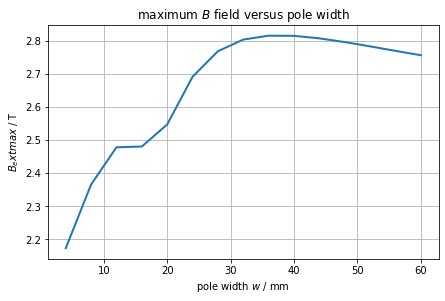

In [39]:
pw = np.linspace(4, 60, (14 + 1))
Bmax = [maxField(w, [1,1,1], [1,1,1], prec = 0.0005) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

We now increase both segmentation arrays, and then compute $B_0$ in a narrower
range of pole-tip widths.

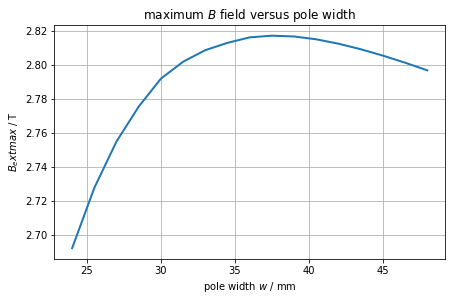

In [40]:
pw = np.linspace(24, 48, (16 + 1))
Bmax = [maxField(w, [2,2,5], [1,3,1], prec = 0.0003) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

You can experiment with further increases to the segmentation:

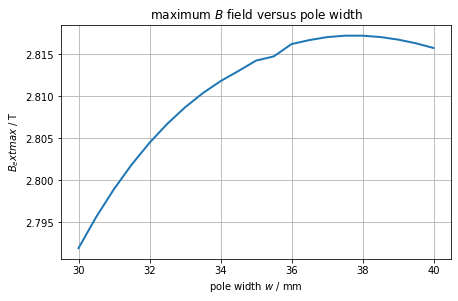

In [41]:
pw = np.linspace(30, 40, (20 + 1))
Bmax = [maxField(w, [4,4,10], [2,6,2], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

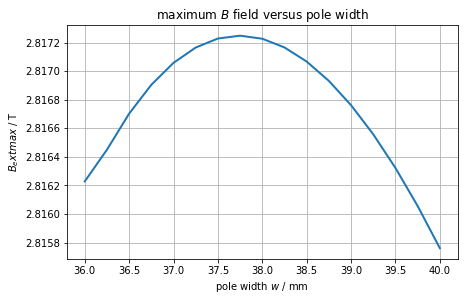

In [42]:
pw = np.linspace(36, 40, (16 + 1))
Bmax = [maxField(w, [4,4,10], [2,6,2], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

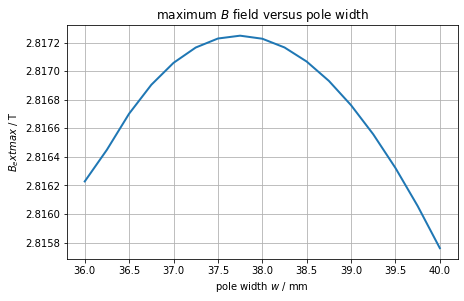

In [43]:
pw = np.linspace(36, 40, (16 + 1))
Bmax = [maxField(w, [4,4,11], [2,6,2], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

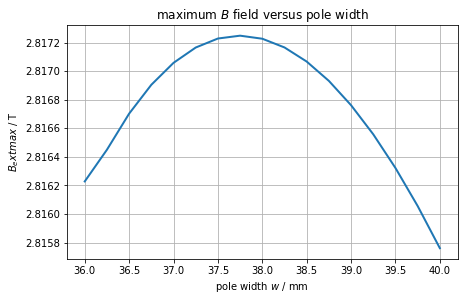

In [44]:
pw = np.linspace(36, 40, (16 + 1))
Bmax = [maxField(w, [4,4,11], [2,6,4], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()

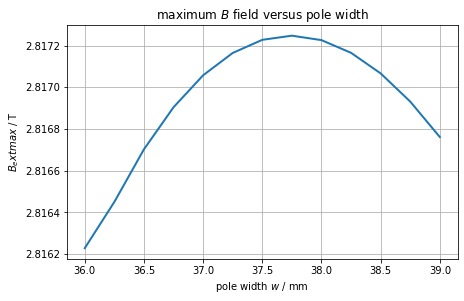

In [45]:
pw = np.linspace(36, 39, (12 + 1))
Bmax = [maxField(w, [6,6,11], [4,4,4], prec = 0.0001) for w in pw]

# plot Bmax vs Pole width
plt.figure(figsize=(7,4.3))
plt.plot(pw, Bmax, linewidth = 2.0)
plt.title(r'maximum $B$ field versus pole width')
plt.xlabel('pole width $w$ / mm')
plt.ylabel('$B_\text{max}$ / T')
plt.grid()
plt.show()